In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import xraydb
import os
import pandas as pd
import re
from mossbauer_theory import CobaltRhodium, CobaltFe, KFeCy, alphaFe, Mossbauer    #import calsses for sources, absorbers, and the mossbauer transmission spectrum
from mossbauer_theory.mossbauer_theory import CobaltRhodium, CobaltFe, KFeCy, alphaFe, Mossbauer
from mossbauer_analysis.fit_functions import linear, poly2,poly5, single_peak_lorentzian_poly1, single_peak_lorentzian_poly2, six_peak_lorentzian_poly1,six_peak_lorentzian_poly2, six_peak_lorentzian_poly5
from mossbauer_analysis.load_spectrum import read_ironanalytics_data, print_ironanalytics_metadata 
import mossbauer_analysis.utils as u
from mossbauer_analysis.analyse_file import fit_and_calibrate


In [2]:
dir ='C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/calibration072025/'
print_ironanalytics_metadata(dir)

#id = 'A00043'
#dat = read_ironanalytics_data(dir, id, offset = -3)


ID: A00108,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: KFeCy_06mms_xx
ID: A00109,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: KFeCy_06mms_x
ID: A00110,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe25um_06mms
ID: A00111,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe10um_06mms
ID: A00112,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe10um_06mms_2
ID: A00113,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe20um_06mms
ID: A00114,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe100um_06mms
ID: A00115,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe25umQuartz500um_06mms
ID: A00117,	 v_max: 16,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe25umQuartz500um_16mms
ID: A00118,	 v_max: 16,	  det: 70,	 10,	 1556,	 3277,	 Description: alphaFe25um_16mms
ID: A00119,	 v_max: 6,	  det: 70,	 10,	 1556,	 3277,	 Description: sample_holder
ID: A00120,	 v_max: 6,	  det: 70,	 10,	 1556,	 32

In [29]:
def total_area_density(elements: dict, reference_element = 'Fe' , reference_element_area_density = 6e-3):
    """Computes total area density from single element area density."""
    mass_sum = sum(val * xraydb.atomic_mass(el) for el, val in elements.items())
    thickness_gcm2 = reference_element_area_density / (elements[reference_element] * xraydb.atomic_mass(reference_element)) * mass_sum
    return thickness_gcm2

def compound_mass_attn(elements: dict, energy: float) -> float:
    """Compute mass attenuation coefficient (cm²/g) for a compound."""
    mass_sum = sum(val * xraydb.atomic_mass(el) for el, val in elements.items())
    mu_mass = sum(xraydb.mu_elam(el, energy) * val * xraydb.atomic_mass(el) / mass_sum
                  for el, val in elements.items())
    return mu_mass

def calculate_total_attenuation(energy, setup):
    total_mu = 0.0
    for material, thickness in setup.items():
        try:
            mu = * thickness * 100
        except Exception:
            mu_mass = compound_mass_attn(eval(f"elements_{material}"), energy)
            mu      = mu_mass * thickness * eval(f"thickness_gcm2_{material}")
        total_mu += mu
    
    return np.exp(-total_mu)
        

def calcuate_background_rates(energies_eV, fluxes, materials, thicknesses_m):
    """Calculate total attenuated background counts from multiple photon energies,
    using thickness in meters."""

    attenuated_fluxes = []
    for E, flux in zip(energies_eV, fluxes):
        total_attenuation = 0.0
        for mat, d_cm in zip(materials, thicknesses_m*100):
            mu = xraydb.material_mu(mat, E)  # linear attenuation coeff in cm⁻¹
            total_attenuation += mu * d_cm
        transmitted = flux * np.exp(-total_attenuation)
        attenuated_fluxes.append(transmitted)

    total_counts = sum(attenuated_fluxes)
    return total_counts, attenuated_fluxes


def solve_wls_system(A, y, dy):
    """
    Perform a weighted least squares fit with uncertainty propagation.

    Parameters:
        A  : np.ndarray  — design matrix (N×M)
        y  : np.ndarray  — measured data (N,)
        dy : np.ndarray  — uncertainties on y (N,)

    Returns:
        x  : np.ndarray  — best-fit parameters (M,)
        dx : np.ndarray  — 1σ uncertainties on parameters (M,)
    """
    W = np.diag(1 / dy**2)
    Aw = W @ A
    yw = W @ y

    x = np.linalg.lstsq(Aw, yw, rcond=None)[0]
    residuals = y - A @ x
    norm_residuals = residuals / dy
    dof = len(y) - len(x)
    reduced_chi2 = np.sum(norm_residuals**2) / dof
    cov_x = np.linalg.inv(A.T @ W @ A) * reduced_chi2
    dx = np.sqrt(np.diag(cov_x))

    y_fit = A @ x
    dy_fit = np.sqrt(np.sum(A @ cov_x * A, axis=1))

    return x, dx, y_fit, dy_fit


## Reference Absorbers: 

0                alphaFe25um_06mms
1                alphaFe10um_06mms
2              alphaFe10um_06mms_2
3                alphaFe20um_06mms
4               alphaFe100um_06mms
5     alphaFe25umQuartz500um_06mms
6     alphaFe25umQuartz500um_16mms
7                alphaFe25um_16mms
8                    sample_holder
9                          nothing
10                         Al_50um
11                cardboardandtape
Name: description, dtype: object

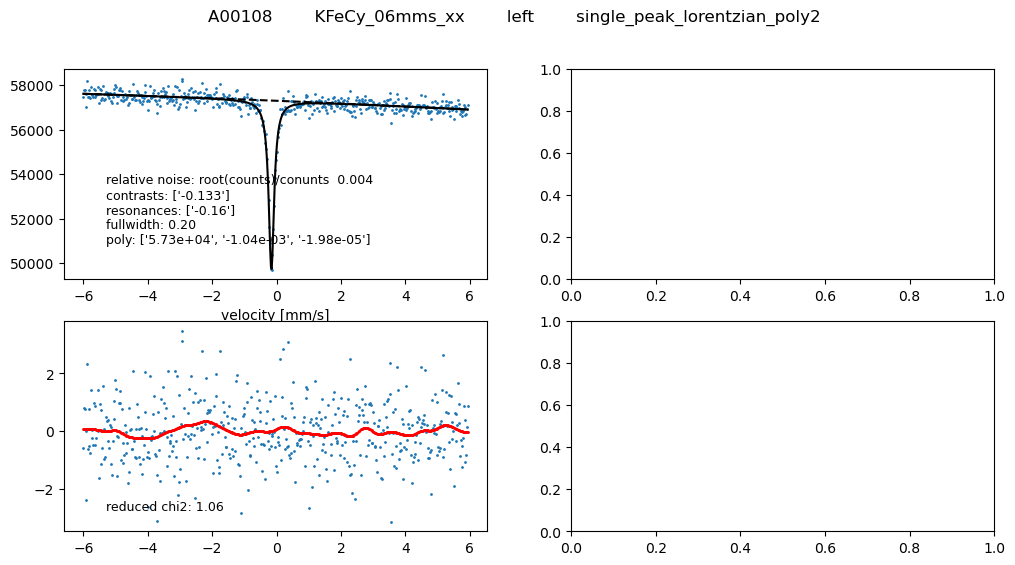

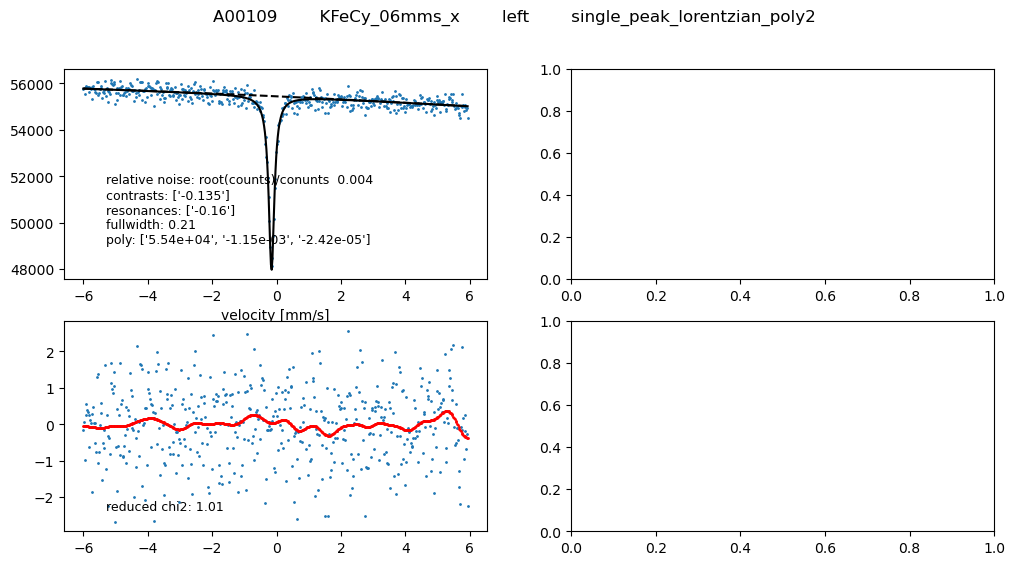

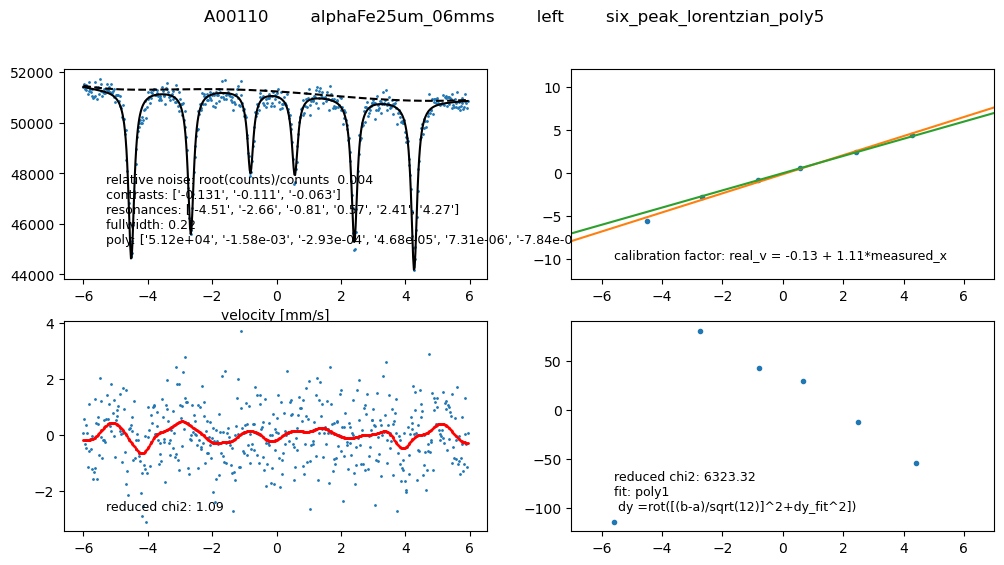

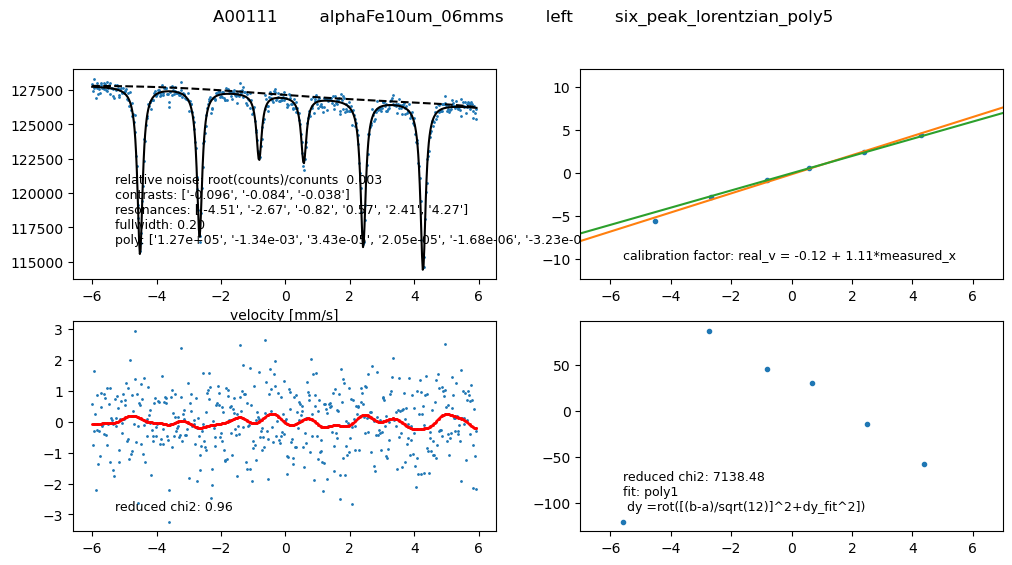

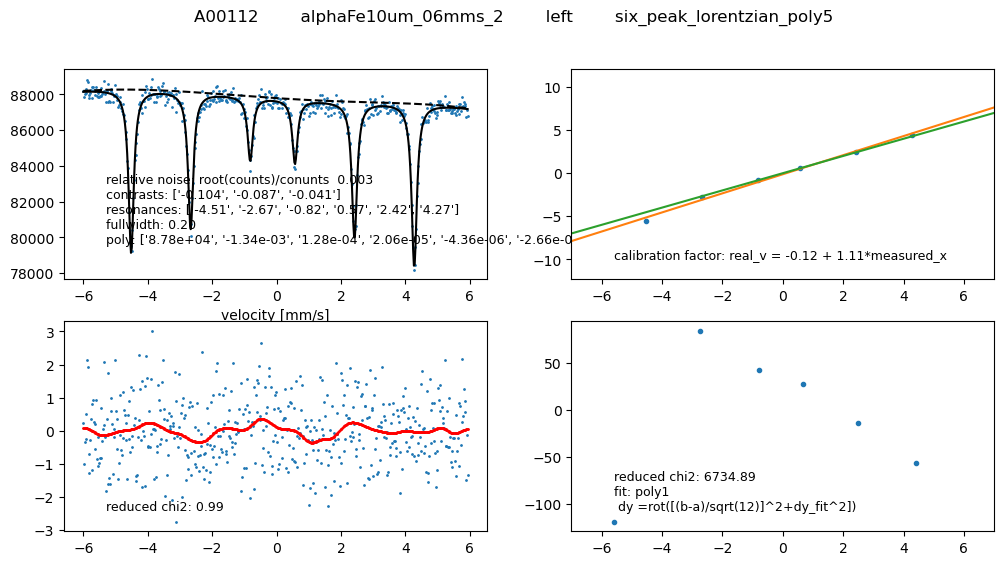

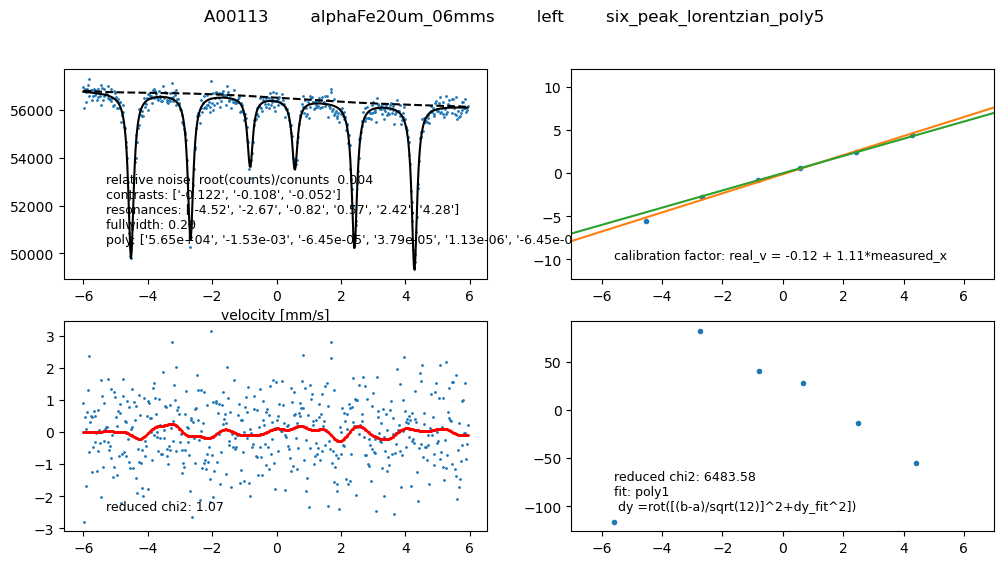

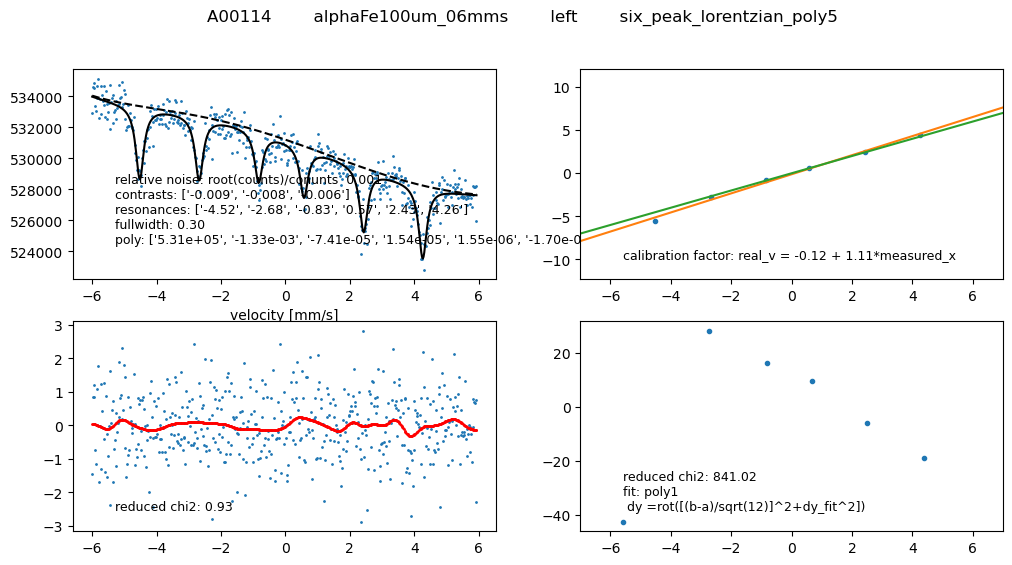

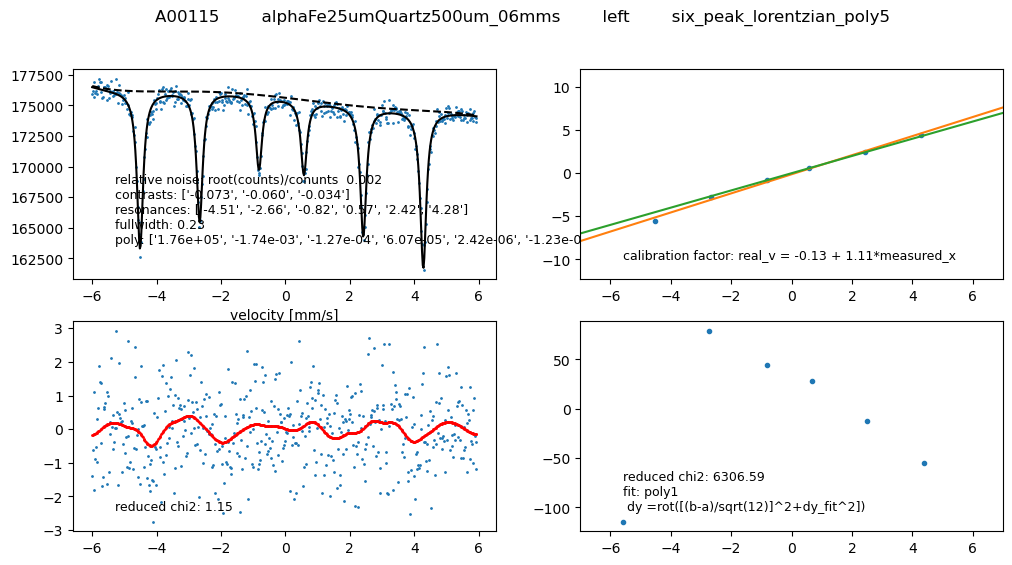

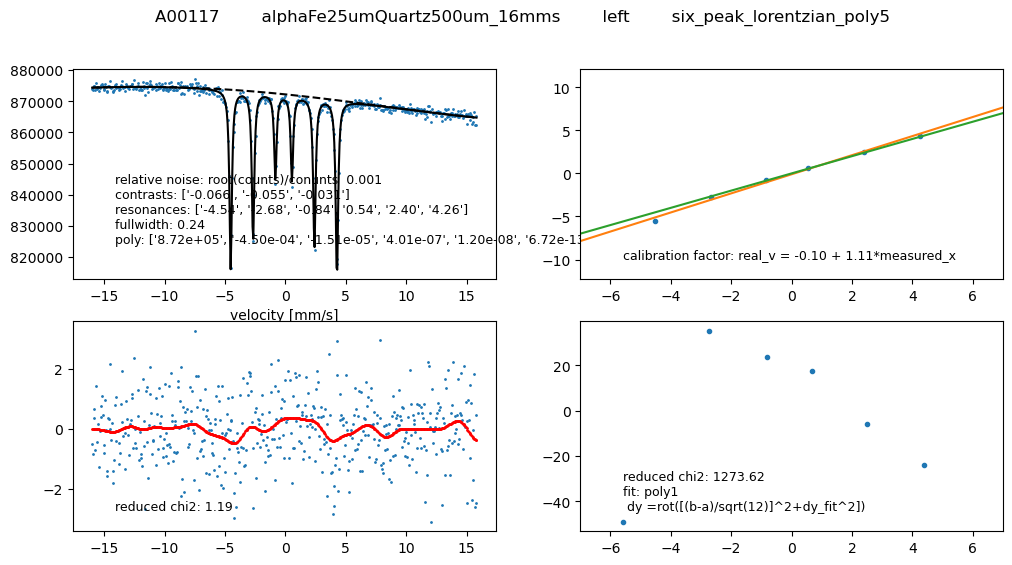

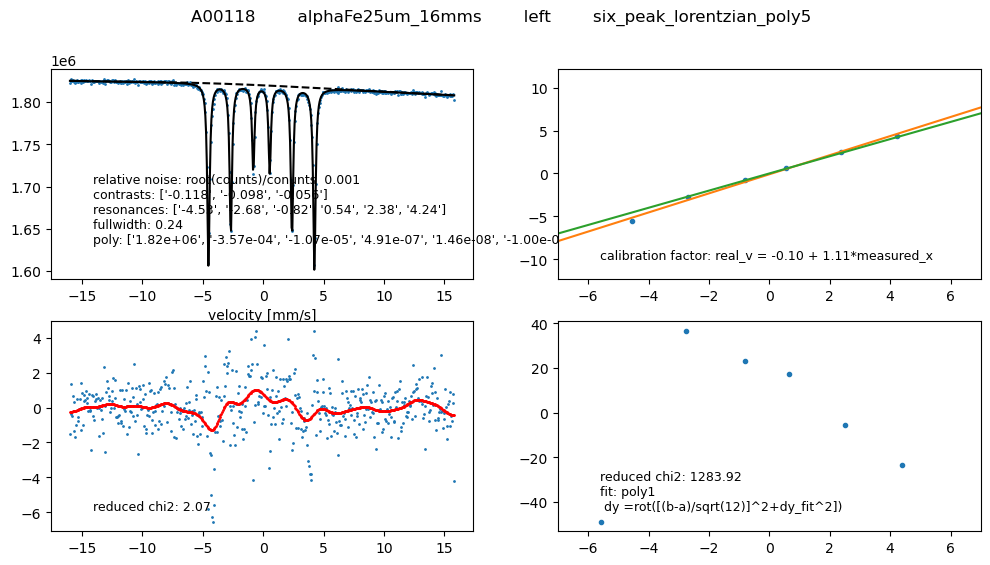

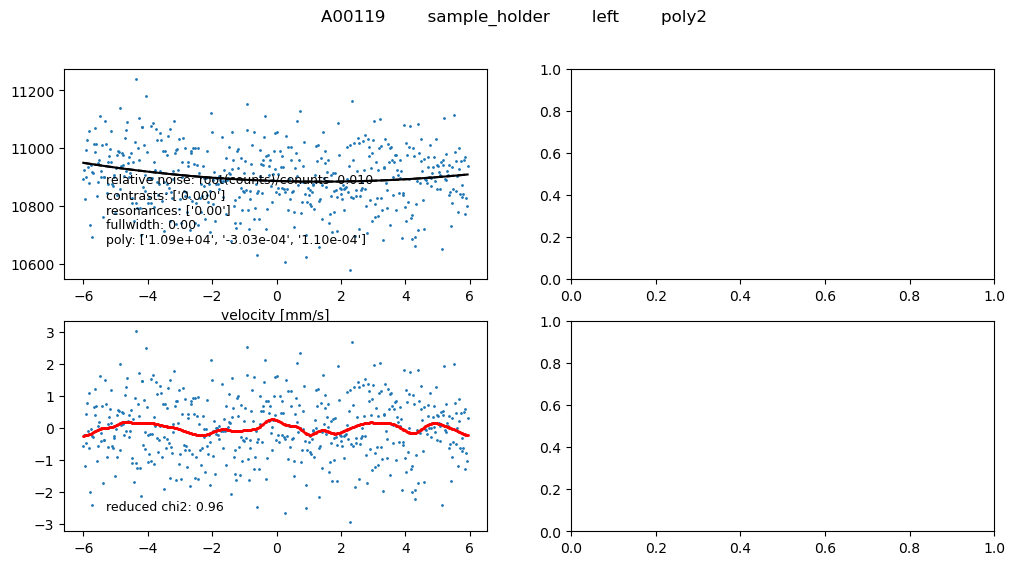

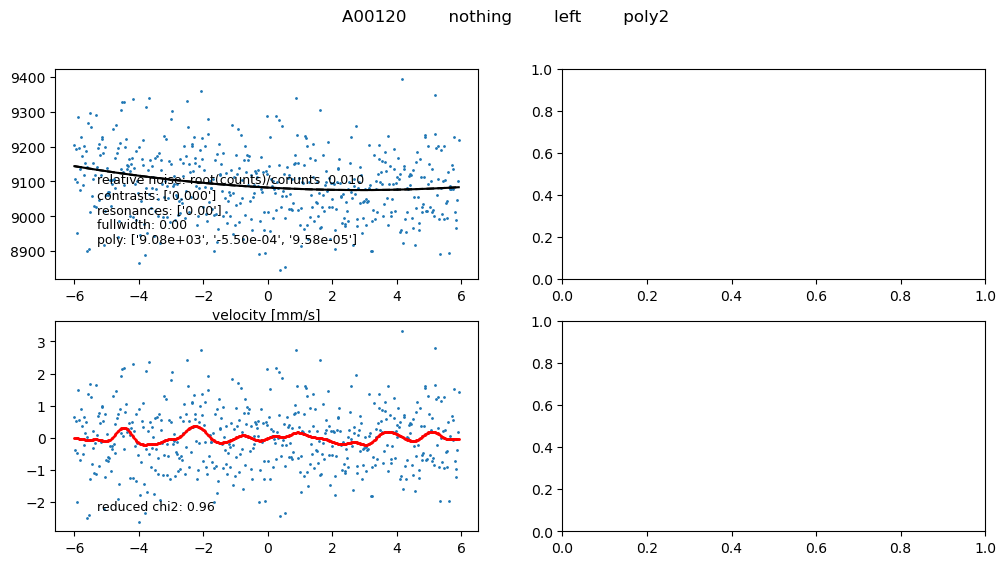

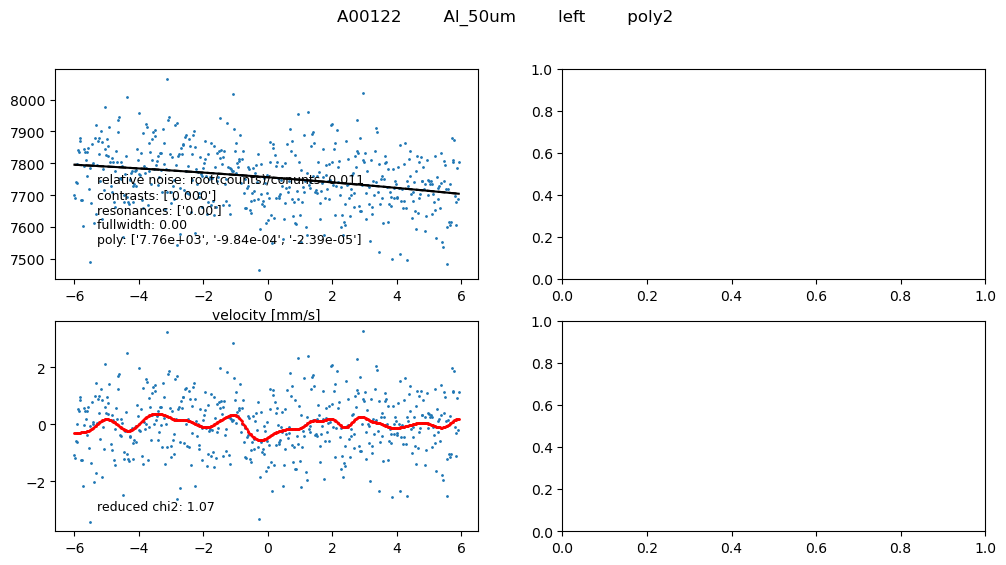

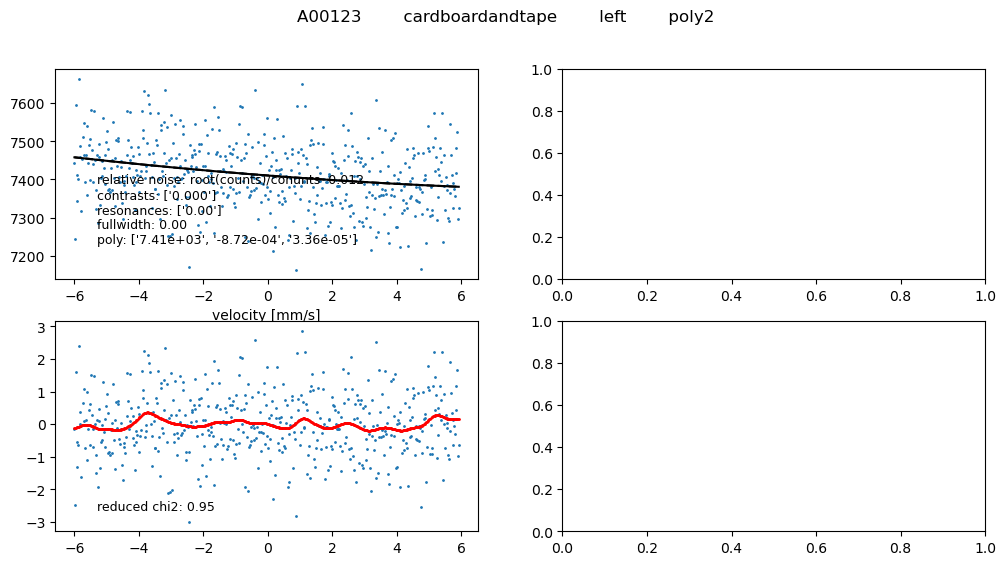

In [218]:

params_out = []


# potrassium ferrocianide
fit_guess = {
        'contrasts': -0.2,
        'resonances': -0.078,
        'fullwidth': 0.2,
        'poly': [1e5, 1e-3, 1e-5],  
        }


params = {  'directory': dir,
        'id': 'A00049',
        'offset': -3,
        'side': 'left',
        'npeaks': 1,
        'fitfunction': single_peak_lorentzian_poly2,
        'calibration_resonances': -0.78,
        
} 


for id in ['A00108', 'A00109']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = True))


params_out = []
#alphaFe
fit_guess = {
            'contrasts': [-1e2, -1e2, -1e2],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.31,4.09],
            'fullwidth': 0.3,
            'poly': [3e6, 1e2, 1e1,1e-2,1e-3,1e-4],  
            }


params = {  'directory': dir,
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': [-5.58, -2.75, -0.8, 0.66, 2.50, 4.4],
        
        } 

for id in ['A00110', 'A00111', 'A00112', 'A00113', 'A00114', 'A00115', 'A00117', 'A00118']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = True, plot = True))


#no Iron
fit_guess = {'poly': [3e6, 1e2, 1e1]}

params = {  'directory': dir,
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': poly2,        
        } 

for id in ['A00119', 'A00120', 'A00122', 'A00123']:#, 'A00124']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = True))


params_df = pd.DataFrame(params_out)
params_df['description']

###
Here we try to evaluate the fluxes of different energy contributions by estimating nonresonant absaortption form different materials. The issue here is that in order to compare properly, we have to integrate for know time, and the short measurements have very large unvertainty...

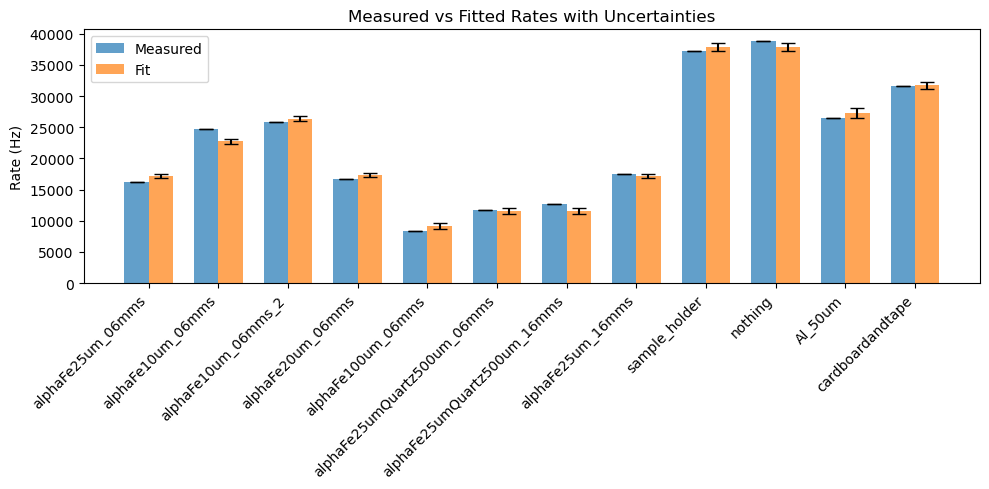

0.3470749109354475 1.0 0.43628855901262603


(None, 0.19705702544629683, 0.0674110008463291, 0.05818662651755034)

In [219]:
# Define photon energies
energies_keV = [6.5e3, 14.4e3, 122.0e3]

# Define measurement setups [m], if cardboard is given in g/m²

elements_Cardboard = {'C': 6, 'H': 10, 'O': 5}
thickness_gcm2_Cardboard = 0.06
elements_KFeCy =  {'Fe': 1, 'K': 4, 'C': 6, 'N': 6, 'H': 6, 'O': 3}
thickness_gcm2_KFeCy = total_area_density(elements_KFeCy, reference_element= 'Fe', reference_element_area_density = 6e-3)

setups = [
#    {"KFeCy":1},
#    {"KFeCy":1},
    {"Fe":25e-6},
    {"Fe":10e-6,       "Cardboard":1},
    {"Fe":10e-6,       "Cardboard":0},
    {"Fe":20e-6,       "Cardboard":1},
    {"Fe":100e-6,      "Cardboard":1},
    {"Fe":25e-6,       "Quartz":0.5e-3},
    {"Fe":25e-6,       "Quartz":0.5e-3},
    {"Fe":25e-6},
     {},
     {},
 #   {"Al":25e-6},
    {"Al":50e-6,       "Cardboard":1},
    {"Cardboard":1},
  #  {"Cardboard":1},
]


# Measured rates and uncertainties
labels = params_df['description']
measured_rates = params_df['total_rate_fit'].values
uncertainties = np.ones(len(measured_rates))#params_df['total_rate_fit_error'].values

# Compute transmission matrix 

T_matrix = []

for setup in setups:
    row = []
    for energy in energies_keV:
        attenuation = calculate_total_attenuation(energy, setup)
        row.append(attenuation)
    T_matrix.append(row)

T_matrix = np.array(T_matrix)

#len(T_matrix), len(measured_rates)
x, dx, y_fit, dy_fit = solve_wls_system(T_matrix, measured_rates, uncertainties)


loc = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(loc - width/2, measured_rates, width, yerr=uncertainties, label="Measured", capsize=5, alpha=0.7)
plt.bar(loc + width/2, y_fit, width, yerr=dy_fit, label="Fit", capsize=5, alpha=0.7)

plt.xticks(loc, labels, rotation=45, ha='right')
plt.ylabel("Rate (Hz)")
plt.title("Measured vs Fitted Rates with Uncertainties")
plt.legend()
plt.tight_layout()
plt.show()

print(x[0]/x[1],x[1]/x[1],x[2]/x[1]),dx[0]/x[0],dx[1]/x[1],dx[2]/x[2]

## just alphaFe 6mm/s, sifferent thicknesses

3.2693684160740755e-15 -0.03824292539120183
3.2693684160740755e-15 -0.04632883971064485
3.652164391159257e-15 15.858523608157782
0.12960401216207448 0.13076151281270396
0.10358265489015918 0.09573589370412133
0.09905299567879153 0.10417624923817588
0.13203437058915632 0.12205673568103248
0.008652727488297545 0.008783436577220796
0.0808987097681583 0.07309184358401193
0.0808987097681583 0.0658787370519887
0.12960401216207448 0.11839981693893596


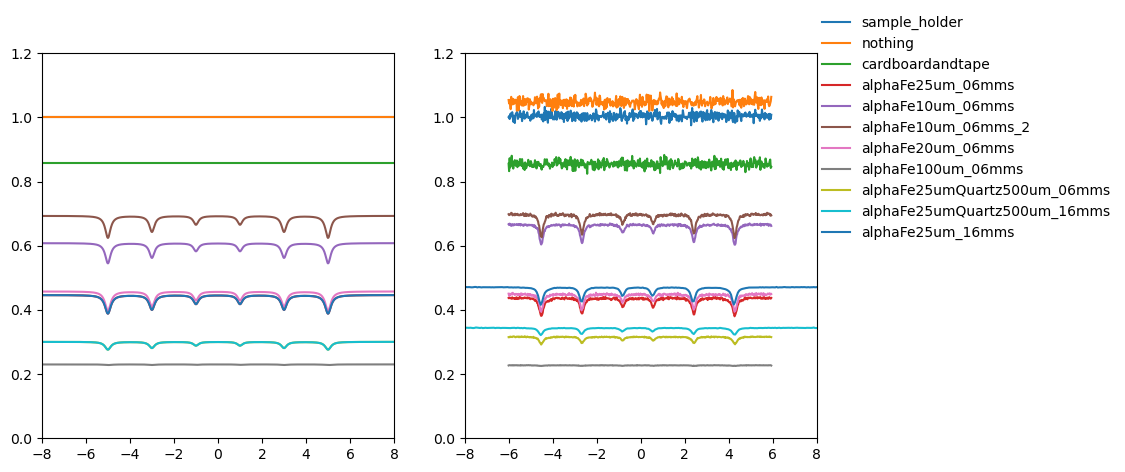

In [220]:
fit_guess = {
            'contrasts': [-1e2, -1e2, -1e2],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.31,4.09],
            'fullwidth': 0.3,
            'poly': [3e6, 1e2, 1e1,1e-2,1e-3,1e-4],  
            }


params = {  'directory': dir,
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': [-5.58, -2.75, -0.8, 0.66, 2.50, 4.4],
        
        } 



fig,ax = plt.subplots(1,2, figsize = (10,5))

setups = [
    {"Fe":0,           "Cardboard":0},
    {"Fe":0,           "Cardboard":0},
    {"Fe":0,           "Cardboard":1},
    {"Fe":25e-6},
    {"Fe":10e-6,       "Cardboard":1},
    {"Fe":10e-6,       "Cardboard":0},
    {"Fe":20e-6,       "Cardboard":1},
    {"Fe":100e-6,      "Cardboard":1},
    {"Fe":25e-6,       "Quartz":500e-6},
    {"Fe":25e-6,       "Quartz":500e-6},
    {"Fe":25e-6       },
]


params_all = []
for i, id in enumerate(['A00119','A00120', 'A00123','A00110','A00111','A00112','A00113','A00114','A00115', 'A00117', 'A00118']):
        params['id'] = id
        params_out = fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = True, plot = False)
        params_out['setup'] = setups[i]
        params_all.append(params_out)
        polyparams = params_out['poly']
        polyparams[0] = 1
        norm = poly5(polyparams,params_out['x'] )
        ax[1].plot(params_out['x'],params_out['y']/params_out['total_time']*1024/37e3/norm, label = params_out['description'] )

ax[1].legend(frameon = False, loc = (1,0.5,))
visall=[] 

for i, params in enumerate(params_all):
    
    source = CobaltRhodium()
    source.current_activity_Ci
    source.Gamma_ev = 9e-9
    source.update_params()
    
    absorber = alphaFe()
    absorber.Gamma_ev = 4e-9
    absorber.thickness_m = params['setup']['Fe'] #thickness  # thickness in m
    absorber.abundance = 0.0212
    absorber.update_params()
    
    moss = Mossbauer(source, absorber)
    
    v = np.linspace(-10,10,1000)
    t = moss.total_transmission_rate(v)*calculate_total_attenuation(14.4e3, params['setup'])
    #print(calculate_total_attenuation(14.4e3, params['setup']),  params['setup'])

    energies = [6.5e3, 122e3]           # eV
    fluxes = [0.0, 0.298]
    fluxes = [.25, 0.38]# relative photon rates
    #fluxes = [0.46, 0.32]
    B=0
    B = np.sum([fluxes[j]*calculate_total_attenuation(energies[j], params['setup']) for j in range(len(energies))])
     
    ax[0].plot(v, (t + B)/(1+np.sum(fluxes)), label = 'Fe')
    vis = (np.max(t + B)-np.min(t + B))/np.max(t + B)
    
    print(vis, -params['contrasts'][0])
    
    visall.append([vis, -params['contrasts'][0]])
    
ax[1].set_ylim(0,1.2)
ax[1].set_xlim(-8,8)
ax[0].set_ylim(0,1.2)
ax[0].set_xlim(-8,8)

visall = np.array(visall[3:]).T

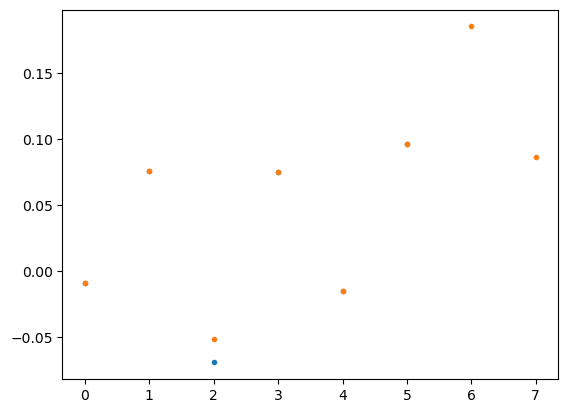

In [221]:
plt.plot((visall0[0]-visall0[1])/visall0[0],'.')
plt.plot((visall[0]-visall[1])/visall[0],'.')
visall0 = visall

In [286]:
distance = 0.1
source.mossbauer_photon_rate/1e6#*area_collimator/(4*np.pi*distance**2)

105.57969230306917

0.031070782271145556 0.028882061030647783


0.28603302097278016

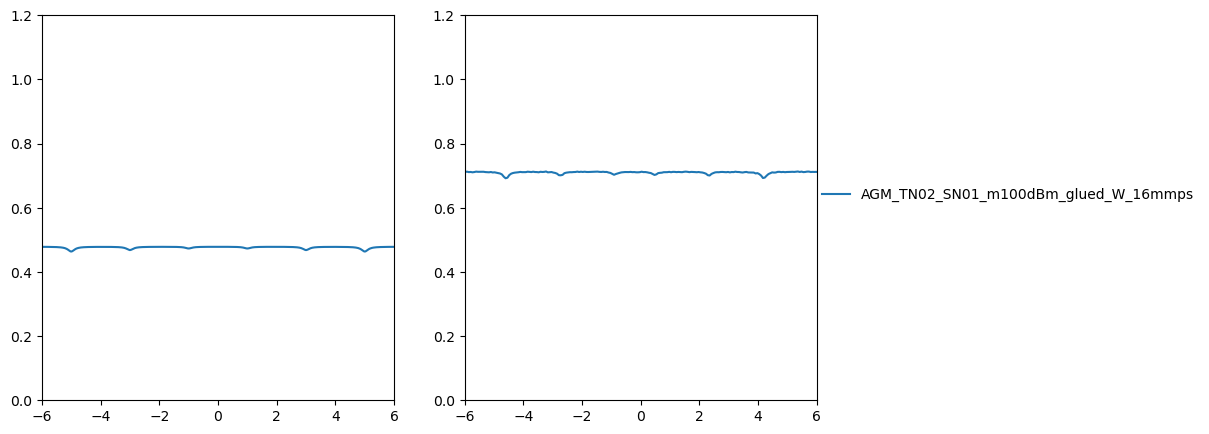

In [293]:
fit_guess = {
            'contrasts': [-1e2, -1e2, -1e2],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.31,4.09],
            'fullwidth': 0.3,
            'poly': [3e6, 1e2, 1e1,1e-2,1e-3,1e-4],  
            }


params = {  'directory':'C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/saw_spectra_16mms/',
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': [-5.58, -2.75, -0.8, 0.66, 2.50, 4.4],
        
        } 


fig,ax = plt.subplots(1,2, figsize = (10,5))

setup = {"Fe":0.09e-6,       "Quartz":500e-6}

params['id'] = 'A00097'
params = fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = False)
params['setup'] = setup

area_Fe = 4e-6
area_W = (4.15*1.35)*1e-6
area_collimator = np.pi*(5e-3)**2


polyparams = params['poly']
polyparams[0] = 1
norm = poly5(polyparams,params['x'] )
solidangle = area_W/area_collimator
ax[1].plot(params_out['x'],params['y']/params['total_time']*1024/37e3/norm/solidangle, label = params['description'] )

ax[1].legend(frameon = False, loc = (1,0.5,))




source = CobaltRhodium()
source.current_activity_Ci
source.Gamma_ev = 9e-9
source.update_params()

absorber = alphaFe()
absorber.Gamma_ev = 4e-9
absorber.thickness_m = params['setup']['Fe']
absorber.abundance = 0.96
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate(v)*calculate_total_attenuation(14.4e3, params['setup'])

energies = [6.5e3, 14.4e3, 122e3]  # eV
fluxes = np.array([.25,0, 0.38]) + max(1-area_Fe/area_W,0) # relative photon rates
#fluxes = [0., 0.38]# relative photon rates
B = np.sum([fluxes[j]*calculate_total_attenuation(energies[j], params['setup']) for j in range(len(energies))])
 
ax[0].plot(v, (t + B)/(1+np.sum(fluxes)), label = 'Fe')
vis = (np.max(t + B)-np.min(t + B))/np.max(t + B)

print(vis, -params['contrasts'][0])

    
ax[1].set_ylim(0,1.2)
ax[1].set_xlim(-6,6)
ax[0].set_ylim(0,1.2)
ax[0].set_xlim(-6,6)

visall = np.array(visall[3:]).T
max(1-area_Fe/area_W,0)

In [296]:
area_Fe
area_W 

5.602500000000001e-06

0.12124463483308795 0.10203213915523643


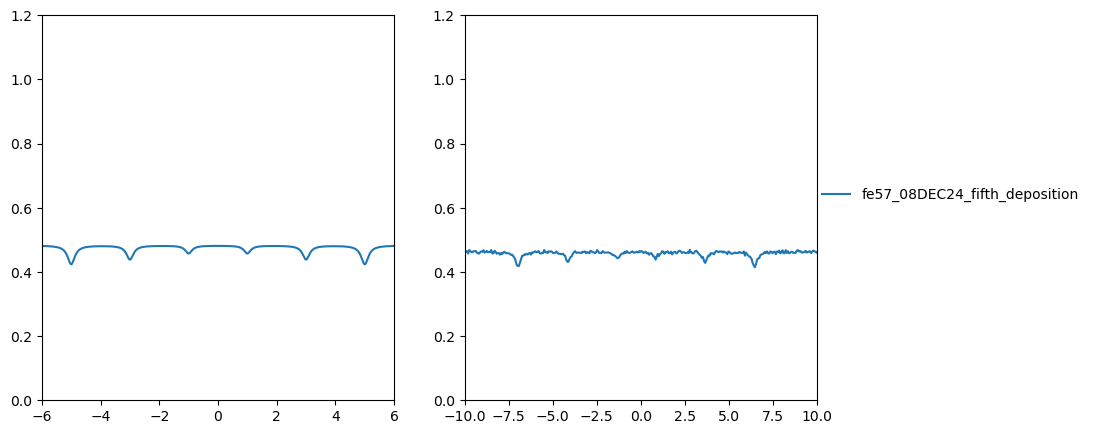

In [298]:
fit_guess = {
            'contrasts': [-1e2, -1e2, -1e2],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.31,4.09],
            'fullwidth': 0.3,
            'poly': [3e6, 1e2, 1e1,1e-2,1e-3,1e-4],  
            }


params = {  'directory':'C:/Users/magrini/Documents/programming/mossbauer_theory/data/SAW_spectra/calbration_spectra',
            'id': 'A00051',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': [-5.58, -2.75, -0.8, 0.66, 2.50, 4.4],
        
        } 


fig,ax = plt.subplots(1,2, figsize = (10,5))

setup = {"Fe":0.3e-6,       "Quartz":500e-6}

params['id'] = 'A00051'
params = fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = False)
params['setup'] = setup

area_Fe = 4e-6
area_W = (4.15*1.35)*1e-6
area_collimator = np.pi*(5e-3)**2


polyparams = params['poly']
polyparams[0] = 1
norm = poly5(polyparams,params['x'] )
solidangle = area_W/area_collimator
ax[1].plot(params_out['x'],params['y']/params['total_time']*1024/2e3/norm, label = params['description'] )

ax[1].legend(frameon = False, loc = (1,0.5,))




source = CobaltRhodium()
source.current_activity_Ci
source.Gamma_ev = 9e-9
source.update_params()

absorber = alphaFe()
absorber.Gamma_ev = 4e-9
absorber.thickness_m = params['setup']['Fe']
absorber.abundance = 0.96
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate(v)*calculate_total_attenuation(14.4e3, params['setup'])

energies = [6.5e3, 14.4e3, 122e3]  # eV
fluxes = np.array([.25,0, 0.38]) # relative photon rates
#fluxes = [0., 0.38]# relative photon rates
B = np.sum([fluxes[j]*calculate_total_attenuation(energies[j], params['setup']) for j in range(len(energies))])
 
ax[0].plot(v, (t + B)/(1+np.sum(fluxes)), label = 'Fe')
vis = (np.max(t + B)-np.min(t + B))/np.max(t + B)

print(vis, -params['contrasts'][0])

    
ax[1].set_ylim(0,1.2)
ax[1].set_xlim(-10,10)
ax[0].set_ylim(0,1.2)
ax[0].set_xlim(-6,6)

visall = np.array(visall[3:]).T

(0.16074300516321668, 0.25, 0.24200000000000002)

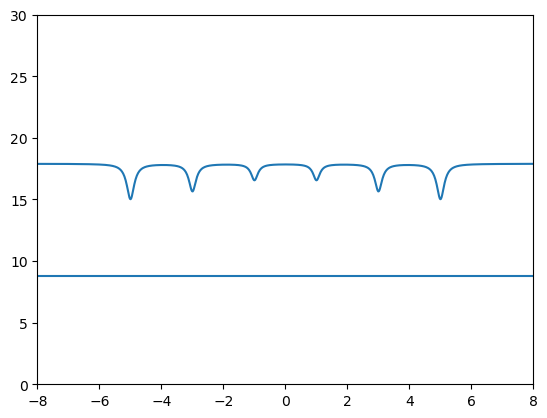

In [58]:
source = CobaltRhodium()
source.Gamma_ev = 8e-9
source.update_params()

absorber = alphaFe()
absorber.Gamma_ev = 4e-9
absorber.thickness_m = 20e-6#thickness  # thickness in m
absorber.abundance = 0.0212
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate
t_norm = t/norm

B = 0.35
plt.plot(v, (t_norm + B)*25, label = 'Fe')
plt.axhline(B*25)

plt.ylim(0,30)
plt.xlim(-8,8)

total_width = absorber.Gamma+source.Gamma
vis =  (max(t_norm + B)-min( t_norm + B))/max(t_norm + B)
vis,total_width, 0.22*1.1

In [32]:
source = CobaltRhodium()
source.Gamma_ev = 9e-9
source.update_params()

absorber = alphaFe()
absorber.Gamma_ev = 5e-9
absorber.thickness_m = 25e-6#thickness  # thickness in m
absorber.abundance = 0.0212
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate


plt.plot(v, t/norm, label = 'Fe')

plt.axhline((1-((t.max()-t.min())/2/t.max()))*moss.non_resonant_attenuation())
plt.axvline(-(source.Gamma + absorber.Gamma)/2)
plt.axvline((source.Gamma + absorber.Gamma)/2)

plt.axhline((1 - source.fs)*moss.non_resonant_attenuation(),color = 'r')
plt.axhline((1 - source.fs*moss.epsilon(absorber.thickness_normalized))*moss.non_resonant_attenuation(),color = 'g')



plt.ylim(0,1)
plt.xlim(-10,10)

total_width = np.sqrt(absorber.Gamma**2+source.Gamma**2)

B = 0.5
vis = moss.epsilon(absorber.thickness_normalized)*source.fs*(1-B)
vis, (t.max()-t.min())/(t.max())*(1-B), source.mossbauer_photon_rate/1e6, moss.non_resonant_attenuation(), total_width

array([[-0.13076151, -0.11115303, -0.06301696],
       [-0.09573589, -0.08398081, -0.03791811],
       [-0.10417625, -0.08701861, -0.04082156],
       [-0.12205674, -0.10767774, -0.05194767],
       [-0.00878344, -0.00770946, -0.00612086],
       [-0.07309184, -0.06025994, -0.03440794]])

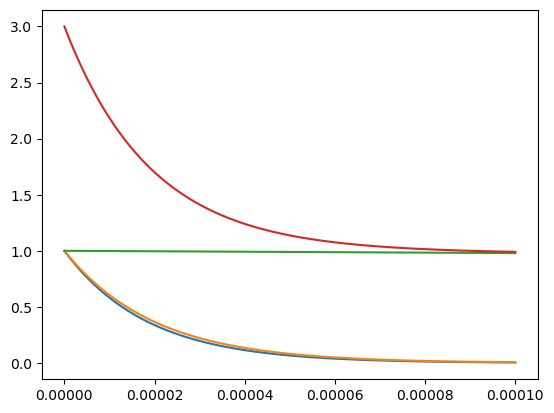

In [90]:
import xraydb

mu_e122 = xraydb.mu_elam('Fe', 122e3)
mu_e14 = xraydb.mu_elam('Fe', 14.4e3)
mu_e6 = xraydb.mu_elam('Fe', 6.47e3)


def calculate_thickness_gcm2(thickness_m, rho = 7.87e3, abundance = 1):
    return thickness_m * rho/10 * abundance

absorber.thickness_gcm2
mu_e122, mu_e14,mu_e6

th = np.linspace(0,1e-4,1000)
th_gcm2  = calculate_thickness_gcm2(th)

plt.plot(th,np.exp(-mu_e6*th_gcm2))
plt.plot(th,np.exp(-mu_e14*th_gcm2))
plt.plot(th,np.exp(-mu_e122*th_gcm2))

plt.plot(th,np.exp(-mu_e6*th_gcm2)+np.exp(-mu_e14*th_gcm2)+np.exp(-mu_e122*th_gcm2))


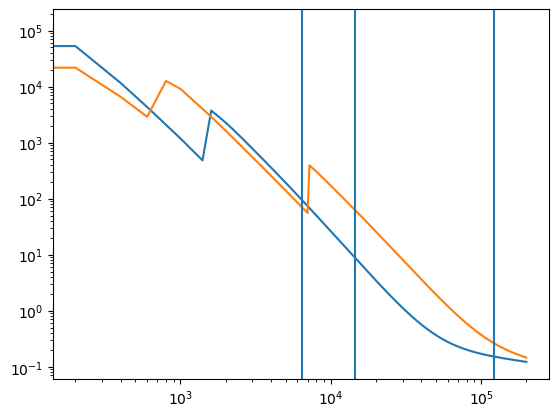

In [165]:
energy = np.linspace(0,200e3,1000)
plt.loglog(energy, xraydb.mu_elam('Al', energy))
plt.loglog(energy, xraydb.mu_elam('Fe', energy))
plt.axvline(6.47e3)
plt.axvline(14.4e3)
plt.axvline(122e3)

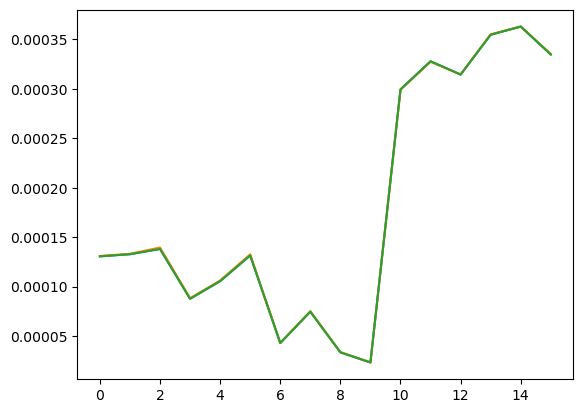

In [78]:
params_out = []

# potrassium ferrocianide
fit_guess = {
        'contrasts': -0.2,
        'resonances': -0.078,
        'fullwidth': 0.2,
        'poly': [1e5, 1e-3, 1e-5],  
        }


params = {  'directory': dir,
        'id': 'A00049',
        'offset': -3,
        'side': 'left',
        'npeaks': 1,
        'fitfunction': single_peak_lorentzian_poly2,
        'calibration_resonances': -0.78,
        
} 


for id in ['A00108', 'A00109']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = False))


#alphaFe
fit_guess = {
            'contrasts': [-1e2, -1e2, -1e2],
            'resonances': [-4.32,-2.55,-0.78,0.55,2.31,4.09],
            'fullwidth': 0.3,
            'poly': [3e6, 1e2, 1e1,1e-2,1e-3,1e-4],  
            }

params = {  'directory': dir,
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': six_peak_lorentzian_poly5,
            'calibration_resonances': [-5.58, -2.75, -0.8, 0.66, 2.50, 4.4],        
        } 

for id in ['A00110', 'A00111', 'A00112', 'A00113', 'A00114', 'A00115']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = False))


#no Iron
fit_guess = {'poly': [3e6, 1e2, 1e1]}

params = {  'directory': dir,
            'id': 'A00043',
            'offset': -3,
            'side': 'left',
            'npeaks': 6,
            'fitfunction': poly2,        
        } 

for id in ['A00119', 'A00120', 'A00121', 'A00122', 'A00123', 'A00124']:
        params['id'] = id
        params_out.append(fit_and_calibrate(params = params , fit_guess = fit_guess, calibrate_resonances = False, plot = False))





0                   KFeCy_06mms_xx
1                    KFeCy_06mms_x
2                alphaFe25um_06mms
3                alphaFe10um_06mms
4              alphaFe10um_06mms_2
5                alphaFe20um_06mms
6               alphaFe100um_06mms
7     alphaFe25umQuartz500um_06mms
8                    sample_holder
9                          nothing
10                         Al_25um
11                         Al_50um
12                cardboardandtape
13                    onlycarboard
Name: description, dtype: object

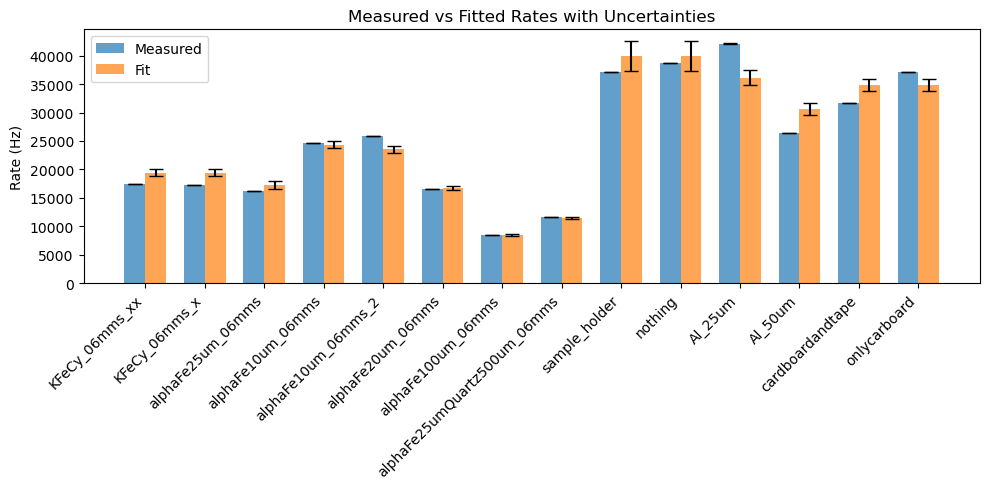

(0.1801538451983585, 1.0, 0.31991371654594125)